In [2]:
import matplotlib.pyplot as plt
from scipy.special import factorial, factorial2
import numpy as np
from decimal import Decimal, getcontext, Context, MAX_EMAX
from tqdm import trange
import random
import math
import time

font = {
    'family' : 'serif',
    'size'   : 15,
    'weight' : 'normal'
}
colors = ['r', 'm', 'darkorange', 'gold', 'darkkhaki', 'lightskyblue']
marker_colors = ['b', 'k', 'indigo', 'maroon', 'darkgreen', 'teal']

plt.rc('font', **font)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', titlesize=22)
plt.rc('legend', fontsize=20)

## 1. Visualization of series terms, partial sums and remainders

### Rate of convergence

Let $a_n > 0$ for all $n\in\mathbb N$ and $\lim\limits_{n\to\infty} a_n = 0$. <u>There are the following types of convergence rate</u>:  
  

**Linear convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = q, \quad 0<q<1.$
    
**Sublinear convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = 1$.
    
**Superlinear convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n} = 0$.
    
**Quadratic convergence:**
    $\lim\limits_{n\to\infty} \frac{a_{n+1}}{a_n^2} = \mu > 0$.

### Partial sums and remainders

For any convergent series $\sum\limits_{n=1}^\infty a_n = S$ with *partial sum* $S_n = \sum\limits_{k=1}^n a_k$ we have  
$$S = S_n + r_n, n\in\mathbb N, $$  
where the sequence $\{r_n\}$, $r_n = \sum\limits_{k=n+1}^\infty a_k$, is called a *tail*, or *remainder*, of the series $\sum\limits_{n=1}^\infty a_n$

Note that for a series with positive terms $S_n$ is increasing, $r_n$ is decreasing.

Code for the class $\texttt{Series}$.

In [3]:
class Series:
    def __init__(self, name, term_implementation, default_sum=0, sum_estimation=None):
        '''
            name, string: labels in LaTeX
            term_implementation: a vectorized function calculating the array of terms
            default_sum, float: sum of initial terms (used if starting index is not 1)
            sum_estimation, float: approximate sum of the series (if known)
        '''
        self.name = name
        self.term_implementation = term_implementation
        self.default_sum = default_sum
        self.sum_estimation = sum_estimation
    
    def calculate_sum(self, begin, end):
        '''
            Calculate the sum a_{begin} + a_{begin + 1} + ... + a_{end - 1}
        '''
        return np.sum(self.terms(begin, end))
    
    def terms(self, n_min, n_max):
        '''
            Returns a numpy array [a_{n_min}, a_{n_min + 1}, ..., a_{n_max - 1}]
        '''
        return self.term_implementation(np.arange(n_min, n_max, dtype=np.float64))
    
    def partial_sums(self, n_min, n_max):
        '''
            Returns a numpy array [S_{n_min}, S_{n_min + 1}, ..., S_{n_max - 1}],
            where S_n is the partial sum of the series
        '''
        return np.cumsum(self.terms(n_min, n_max))
    
    def remainders(self, n_min, n_max):
        '''
            Returns a numpy array [r_{n_min}, r_{n_min + 1}, ..., r_{n_max - 1}],
            where r_n = S - S_n, S is an estimation of the sum of the series
        '''
        assert self.sum_estimation is not None
        return np.array(self.sum_estimation - self.partial_sums(n_min, n_max))
    
    def estimate_sum(self, n_min, n_max):
        '''
            Estimate the sum of the series as a big enough partial sum:
            a_{n_min} + a_{n_min + 1} + ... + a_{n_max}
        '''
        self.sum_estimation = self.calculate_sum(n_min, n_max)
        return self.sum_estimation

In [4]:
def plot(functions, n_min, n_max, title, semilogy=False, y_lims=None):
    plt.figure(figsize=(14, 7))
    
    line_colors = np.random.choice(colors, size=len(functions), replace=False)
    marker_edge_colors = np.random.choice(marker_colors, size=len(functions), replace=False)
    plot = plt.semilogy if semilogy else plt.plot
    
    for index, series in enumerate(functions):
        domain = np.arange(n_min, n_max + 1)
        if title == 'Terms':
            func = series.terms
        elif title == 'Partial sums':
            func = series.partial_sums
        elif title == 'Remainders':
            func = series.remainders
        else:
            raise ValueError('Unknown title!')
        if n_max - n_min < 50:
            plot(domain, func(domain[0], domain[-1] + 1), c=line_colors[index], lw=3,
                 markeredgecolor=marker_edge_colors[index], mew=2, marker='o', label=series.name)
        else:
            plot(domain, func(domain[0], domain[-1] + 1), c=line_colors[index], lw=3, label=series.name)
        if title == 'Partial sums':
            plot(domain, series.sum_estimation * np.ones_like(domain), '--', c=line_colors[index])

    plt.grid(ls=':')
    plt.title(title)
    plt.xlim(n_min, n_max)
    if y_lims is not None:
        if semilogy:
            plt.ylim(10 ** y_lims[0], 10 ** y_lims[1])
        else:
            plt.ylim(y_lims[0], y_lims[1])
    plt.legend();

Some standard series:
$$
\sum_{n=1}^{\infty} \frac 1{n(n+1)}, \quad \sum_{n=0}^{\infty} \Big(\frac 12 \Big)^n,
\quad \sum_{n=0}^{\infty} \frac 1{n!}, \quad \sum_{n=1}^{\infty} (0.99)^{2^n}:
$$

In [5]:
standard_series = [
    Series(r'$\sum{\frac{1}{n(n+1)}}$', lambda x: 1 / x / (x + 1), sum_estimation=1),
    Series(r'$\sum{\frac{1}{2^n}}$', lambda x: 0.5 ** x, default_sum=1, sum_estimation=2),
    Series(r'$\sum{\frac{1}{n!}}$', lambda x: 1 / factorial(x), default_sum=1, sum_estimation=np.e),
    Series(r'$\sum{(0.99)^{2^{n}}}$', lambda x: 0.99 ** (2 ** x))
]

Plotting the first $40$ terms of these series:

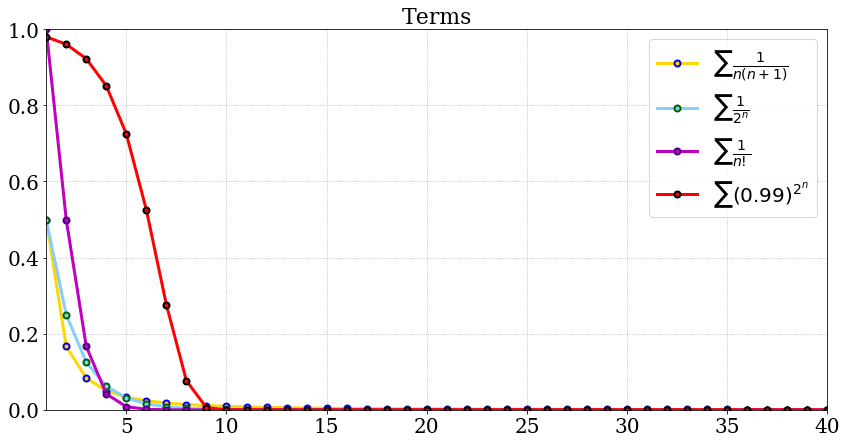

In [6]:
plot(standard_series, 1, 40, 'Terms', y_lims=(0, 1))

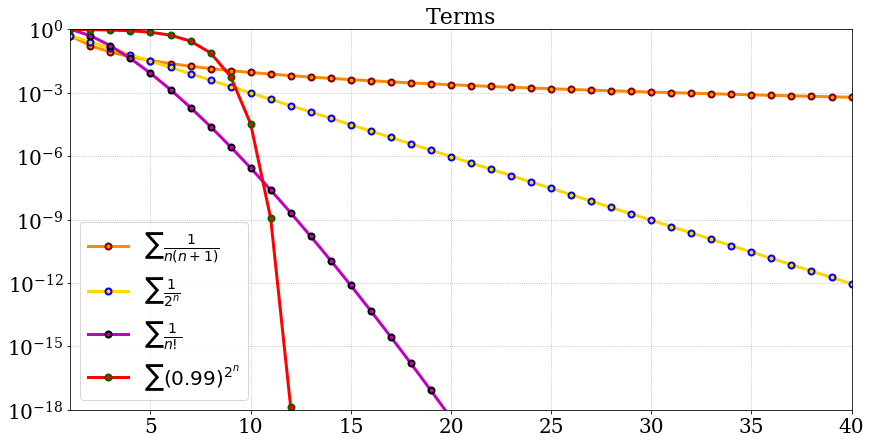

In [7]:
plot(standard_series, 1, 40, 'Terms', semilogy=True, y_lims=(-18, 0))

Here we can see all the different convergence types on this plot.

Plotting the partial sums along with sums of the series.

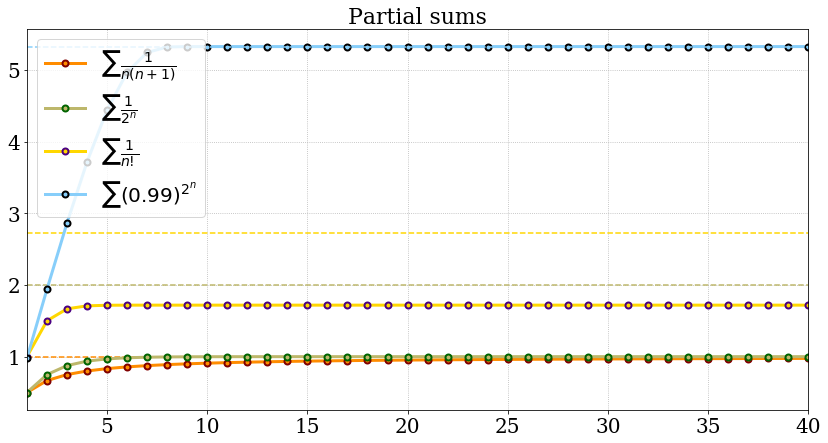

In [8]:
standard_series[-1].estimate_sum(1, 20)
plot(standard_series, 1, 40, 'Partial sums')

Plotting the remainders:

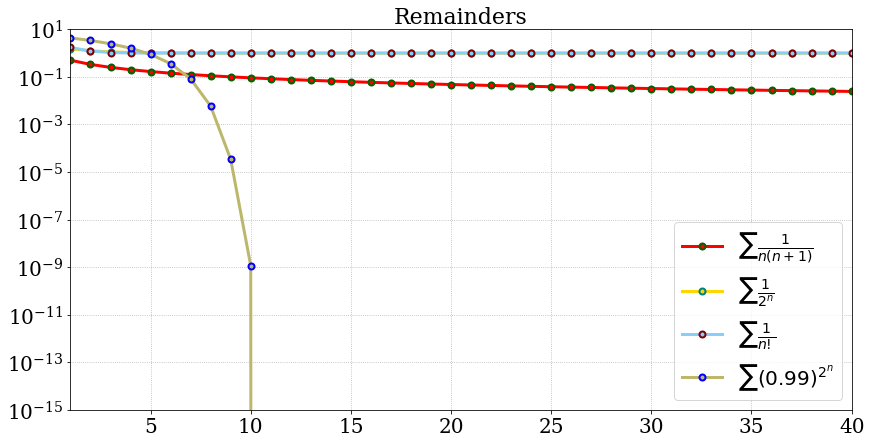

In [9]:
plot(standard_series, 1, 40, 'Remainders', semilogy=True, y_lims=(-15, 1))

Note that for each series the rate of convergence of its terms coincides with that of the remainders.

Consider the series $\sum\limits_{n=1}^\infty a_n$, $\sum\limits_{n=1}^\infty b_n$, $\sum\limits_{n=1}^\infty c_n$, where

$$
a_n = \sum\limits_{n=1}^\infty \frac{(2n-1)!!}{n^n}, \quad
b_n = \sum\limits_{n=1}^\infty \frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}, \quad
c_n = \sum\limits_{n=1}^\infty \Big(\Big(1+\frac 1n\Big)^{n+1} - e\Big)^4.
$$

Determining the rate of convergence to $0$ of the sequences $a_n$, $b_n$, $c_n$ and establishing the convergence of each series  $\sum\limits_{n=1}^\infty a_n$, $\sum\limits_{n=1}^\infty b_n$, $\sum\limits_{n=1}^\infty c_n$.

To determine rate of convergence for the series: $\sum_{1}^{\infty} \frac{(2n-1)!!}{n^n}$, it is required to find the follwoing limit:

$$\lim_{x\to\infty}\Big[ \frac{(2(n+1)-1)!!}{(n+1)^{n+1}} \cdot \frac{n^n}{(2n-1)!!}\Big] = \lim_{x\to\infty}\Big[ \frac{(2n+1)!!}{(n+1)^{n+1}} \cdot \frac{n^n}{(2n-1)!!}\Big] = \lim_{x\to\infty}\Big[ \frac{2n+1}{n+1} \cdot (\frac{n}{n+1})^{n}\Big] = \\ \lim_{x\to\infty}\Big[ \frac{2n+1}{n+1} \cdot (1 + \frac{1}{n})^{-n}\Big] = \frac{1}{e} \cdot \frac{2}{1} = \frac{2}{e}$$

$0 \leq \frac{2}{e} \leq 1$, thus it is linearly convergent.
It is clear that the series converges by ratio test, as $\lim_{x\to\infty}\frac{a_{n+1}}{a_n} = \frac{2}{e} \leq 1$


To determine rate of convergence for the series: $\sum_{1}^{\infty} \frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}$, it is required to find the follwoing limit:

$$\lim_{x\to\infty}\Big[\frac{\sqrt{(n+1)^5+(n+1)^3+2}}{(1.2)^{(n+1)^2}} \cdot \frac{(1.2)^{n^2}}{\sqrt{n^5+n^3+2}}\Big]=
\lim_{x\to\infty}\Big[\sqrt{\frac{(n+1)^5+(n+1)^3+2}{n^5+n^3+2}} \cdot \frac{(1.2)^{n^2}}{(1.2)^{(n^2 + 2n+1)}}\Big[=
\lim_{x\to\infty}\Big[\sqrt{\frac{(n+1)^5+(n+1)^3+2}{n^5+n^3+2}} \cdot \frac{1}{(1.2)^{2n+1}}\Big]=
\lim_{x\to\infty}\Big[\sqrt{\frac{\frac{(n+1)^5}{n^5}+\frac{(n+1)^3}{n^5}+\frac{2}{n^5}}{\frac{n^5}{n^5}+\frac{n^3}{n^5}+\frac{2}{n^5}}} \cdot \frac{1}{(1.2)^{2n+1}}\Big]= \\
\lim_{x\to\infty}\Big[\sqrt{\frac{1}{1}} \cdot \frac{1}{(1.2)^{2n+1}}\Big] = 0$$

As limit is equal to 0, thus it is superlinear convergence.
It is clear that the series converges by ratio test, as $\lim_{x\to\infty}\frac{b_{n+1}}{b_n} = 0 \leq 1$

To determine rate of convergence of the series: $c_n = \sum\limits_{n=1}^\infty \Big(\Big(1+\frac 1n\Big)^{n+1} - e\Big)^4$: it is required to find the following limit:

$$\lim_{x\to\infty}\Big[\frac{\Big(\Big(1+\frac {1}{n+1}\Big)^{n+2} - e\Big)^4}{\Big(\Big(1+\frac 1n\Big)^{n+1} - e\Big)^4}\Big]=
\lim_{x\to\infty}\Bigg[\Bigg(\frac{\Big(1+\frac {1}{n+1}\Big)^{n+2} - e}{\Big(1+\frac 1n\Big)^{n+1} - e}\Bigg)^4\Bigg]=
\lim_{x\to\infty}\Bigg[\Bigg(\frac{\Big(1+\frac {1}{n+1}\Big)^{n+1}\cdot(1+\frac{1}{n+1}) - e}{\Big(1+\frac 1n\Big)^{n}\cdot(1+\frac{1}{n}) - e}\Bigg)^4\Bigg]=
\lim_{x\to\infty}\Bigg[\Bigg(\frac{e\cdot(1+\frac{1}{n+1}) - e}{e\cdot(1+\frac{1}{n}) - e}\Bigg)^4\Bigg]=
\lim_{x\to\infty}\Bigg[\Bigg(\frac{e + \frac{e}{n+1} - e}{e + \frac{e}{n} - e}\Bigg)^4\Bigg]=
\lim_{x\to\infty}\Bigg[\Bigg(\frac{n}{n+1}\Bigg)^4\Bigg] = 1^4 = 1
$$

As limit is equal to 1, thus it is sublinear convergence.
Also series is convergent by limit comparison test. Take $\sum_1^\infty \Big(\frac{3}{n}\Big)^4$, which is convergent by ratio test, which is provided below:
$\sum_1^\infty \frac{1}{n}^3$ is convergent as it is p-series with p > 1.
$$\lim_{x\to\infty}\frac{\Bigg(\frac{3}{n}\Bigg)^4}{\frac{1}{n^3}} = \lim_{x\to\infty}\frac{81 \cdot n^3}{n^4} = \lim_{x\to\infty} \frac{81}{n} = 0 < 1$$

Let's get back to our initial series and apply limit comparison test:
$$\lim_{x\to\infty}\frac{\Big(\Big(1+\frac 1n\Big)^{n+1} - e\Big)^4}{\Big(\frac{3}{n}\Big)^4} =
\lim_{x\to\infty}\frac{e^4\Big(1+\frac{1}{n} - 1\Big)^4}{\Big(\frac{3}{n}\Big)^4} = 
\lim_{x\to\infty}\frac{e^4 \frac{n^4}{n^4}}{3^4} = 
\frac{e^4}{3^4}$$
$0<\frac{e^4}{3^4}<1 \Rightarrow$ as $\sum_1^\infty \Big(\frac{3}{n}\Big)^4$ converges, $\sum\limits_{n=1}^\infty \Big(\Big(1+\frac 1n\Big)^{n+1} - e\Big)^4$ converges too.

Plotting the sequences $a_n$, $b_n$, $c_n$ on the same picture. Considering three cases $n_{\max} = 20, 50, 100$.

/Users/korneytomashchuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':


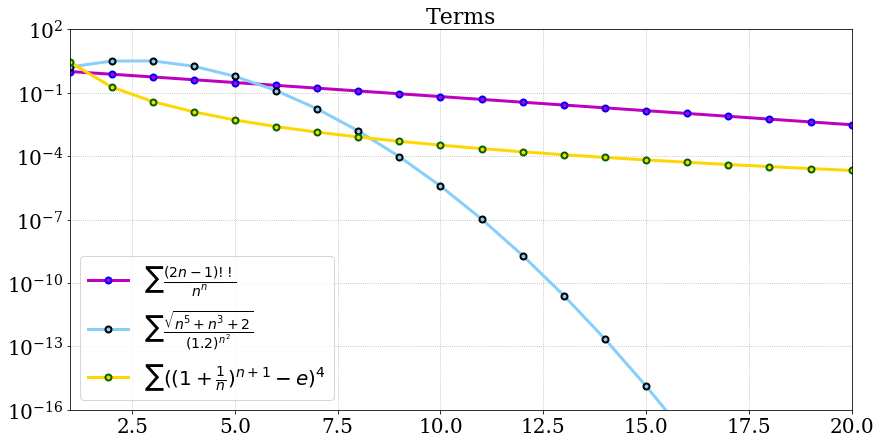

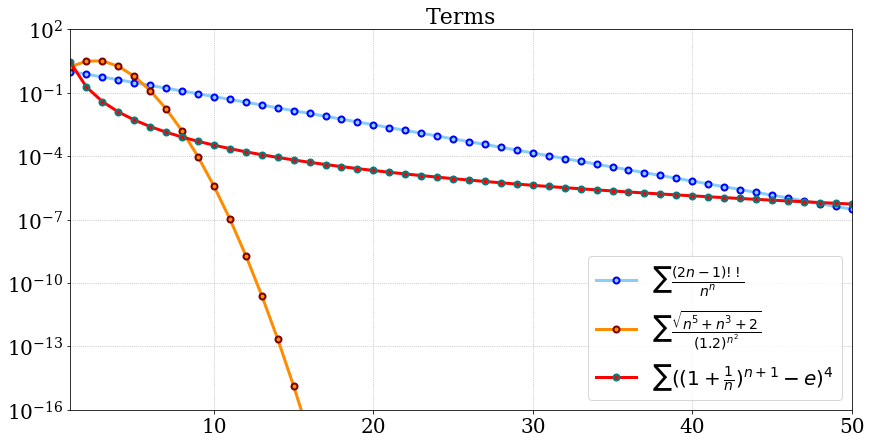

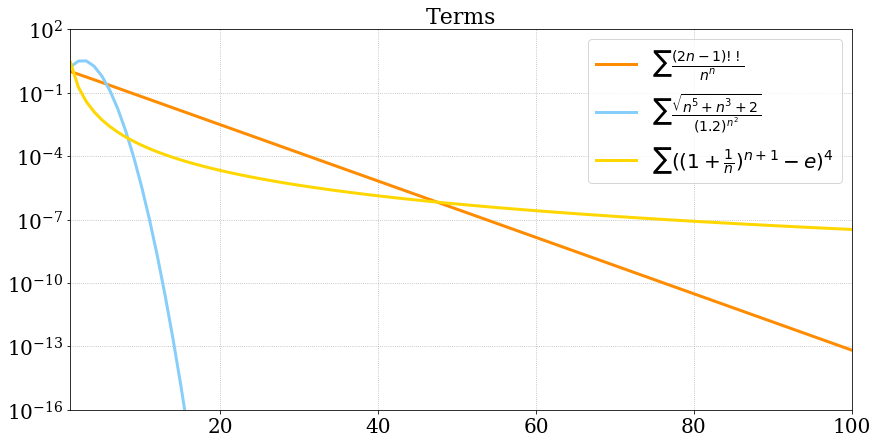

In [10]:
def fac2(x):
    s = np.sum(list(map(math.log, np.arange(x, 1, -2))))
    return np.e**(s)

def a_n(domain):
    domain = list(domain)
    for i in range(len(domain)):
        domain[i] = fac2(2*domain[i] - 1) / (domain[i]**domain[i])
    return np.array(domain)

def b_n(domain):
    domain = ((domain**5 + domain**3 + 2)**(1/2) / 1.2**(domain**2))
    return domain

def c_n(domain):
    domain = ((1 + 1/domain)**(domain+1)-np.e)**4
    return domain

series_list = [
    Series(r'$\sum{\frac{(2n-1)!!}{n^n}}$', a_n),
    Series(r'$\sum {\frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}}$', b_n),
    Series(r'$\sum {((1+\frac {1}{n})^{n+1} - e)^4}$', c_n)
]

plot(series_list, 1, 20, 'Terms', semilogy=True, y_lims=(-16, 2))
plot(series_list, 1, 50, 'Terms', semilogy=True, y_lims=(-16, 2))
plot(series_list, 1, 100, 'Terms', semilogy=True, y_lims=(-16, 2))

We can see different type of convergence on the graph. Clearly, the series $\sum_1^{\infty}{\frac{(2n-1)!!}{n^n}}$  has linear convergence, as on the graph it looks like the straight line. As series $\sum_1^{\infty} {\frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}}$ has superlinear convergence, it has to decrease faster than other two. The following situation we can see on the graph. Finally, series $\sum_1^{\infty}{((1+\frac {1}{n})^{n+1} - e)^4}$ deacreases with the slowest rate, demonstraiting sublinear convergence.

Finding the smallest possible partial sums (i. e., the smallest possible $N_a$, $N_b$, $N_c$) in order to calculate the sums of the series with accuracy $10^-{16}$.

In [16]:
%%time

def a_term(x):
    x = fac2(2*x - 1) / (x**x)
    return x

def b_term(x):
    x = ((x**5 + x**3 + 2)**(1/2) / 1.2**(x**2))
    return x

def c_term(x):
    x = ((1 + 1/x)**(x+1)-np.e)**4
    return x
    

i = 1
eps = 10**(-16)
a_s = a_term(i)
b_s = b_term(i)
c_s = c_term(i)
a_n, b_n, c_n = 0, 0, 0

while a_n == 0 or b_n == 0 or c_n == 0:
    i += 1
    
    if a_n == 0:
        a_s_new = a_s + a_term(i)
    if b_n == 0:
        b_s_new = b_s + b_term(i)
    if c_n == 0:
        c_s_new = c_s + c_term(i)
    
    if a_s_new - a_s < eps and a_n == 0:
        a_n = i
    if b_s_new - b_s < eps and b_n == 0:
        b_n = i
    if c_s_new - c_s < eps and c_n == 0:
        c_n = i
        
    a_s = a_s_new
    b_s = b_s_new
    c_s = c_s_new

    
N_a = a_n
N_b = b_n
N_c = c_n

sum_a = series_list[0].estimate_sum(1, N_a)
sum_b = series_list[1].estimate_sum(1, N_b)
sum_c = series_list[2].estimate_sum(1, N_c)

CPU times: user 29.1 ms, sys: 4.72 ms, total: 33.8 ms
Wall time: 31.4 ms


In [17]:
print("Sizes of partial sums: N_a = {}, N_b = {}, N_c = {}".format(N_a, N_b, N_c))

Sizes of partial sums: N_a = 119, N_b = 16, N_c = 11134


In [18]:
print("Sum estimations: S_a = {}, S_b = {}, S_c = {}".format(sum_a, sum_b, sum_c))

Sum estimations: S_a = 3.8627303358663836, S_b = 10.516939669523996, S_c = 2.946989957076794


Plotting the partial sums of the given series on the same picture. Considering three cases $n_{\max} = 10, 20, 40$.

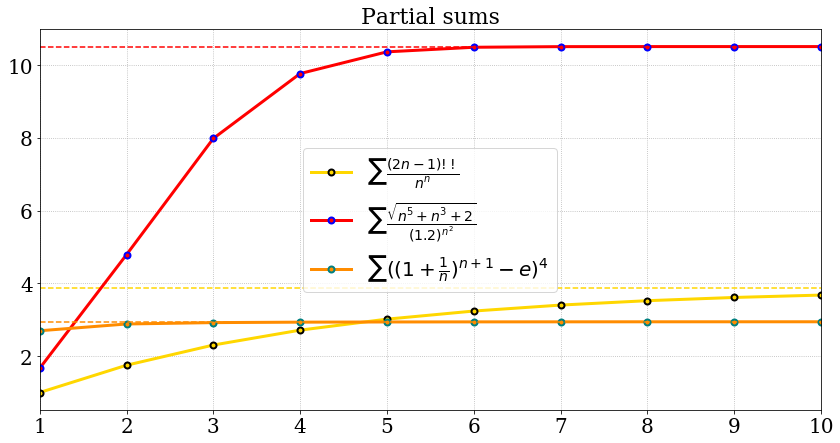

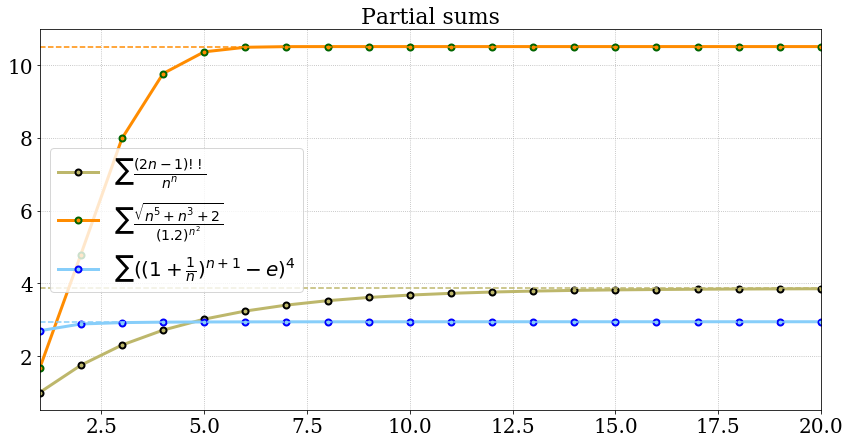

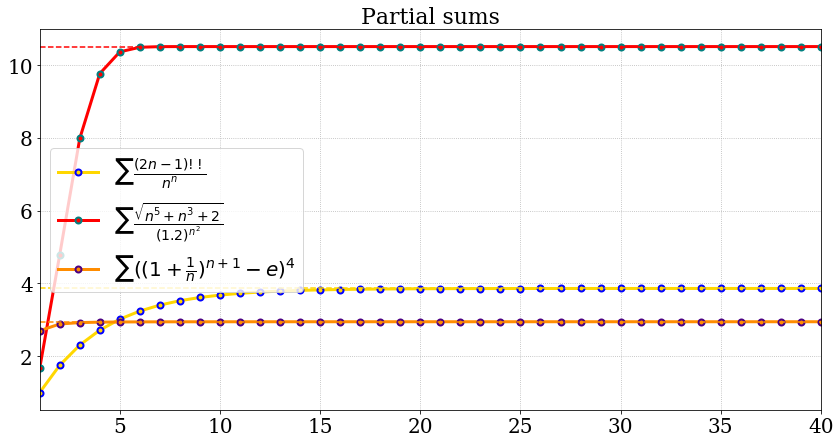

In [19]:
standard_series[-1].estimate_sum(1, 10)
plot(series_list, 1, 10, 'Partial sums')

standard_series[-1].estimate_sum(1, 20)
plot(series_list, 1, 20, 'Partial sums')

standard_series[-1].estimate_sum(1, 40)
plot(series_list, 1, 40, 'Partial sums')

Plotting the remainders of the given series on the same picture in the logarithmic scale. Considering three cases $n_{\max} = 25, 50, 100$.

/Users/korneytomashchuk/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in power
  if sys.path[0] == '':


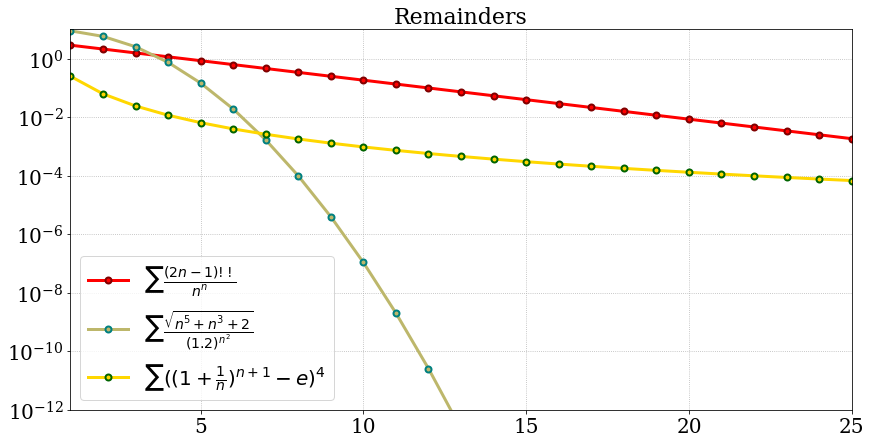

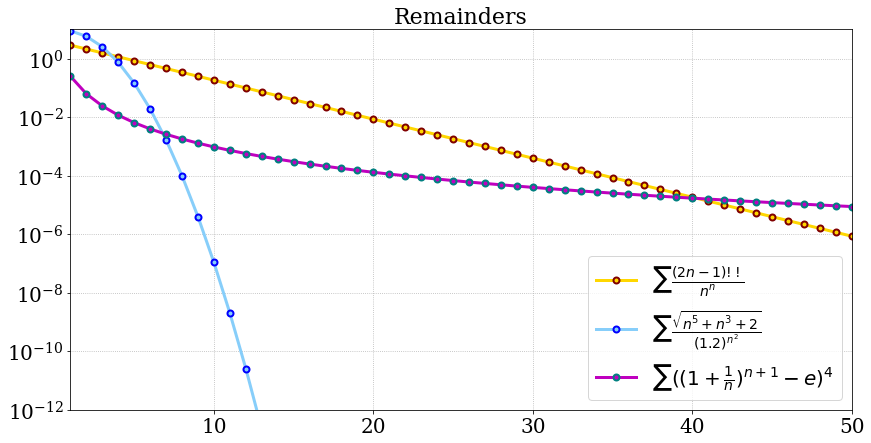

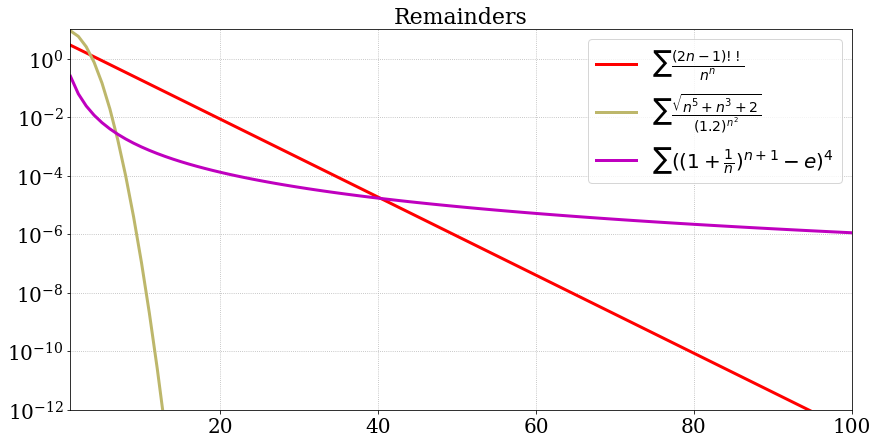

In [20]:
plot(series_list, 1, 25, 'Remainders', semilogy=True, y_lims=(-12, 1))
plot(series_list, 1, 50, 'Remainders', semilogy=True, y_lims=(-12, 1))
plot(series_list, 1, 100, 'Remainders', semilogy=True, y_lims=(-12, 1))

It can be denoted that the rates of convergence of the remainders coincide with that of terms $a_n$, $b_n$, $c_n$.
<br>
The remainders of the following series $\sum_1^{\infty}{\frac{(2n-1)!!}{n^n}}$ has linear convergence, as graph looks like straight line. Also, we can see that remainders of $\sum_1^{\infty} {\frac{\sqrt{n^5+n^3+2}}{(1.2)^{n^2}}}$ decrease extrimelly fast and clearly showing superlinear convergence. Finally, remainders of $\sum_1^{\infty}{((1+\frac {1}{n})^{n+1} - e)^4}$ decrease with the slowest rate, demostrating sublinear convergence.

## 2. High precision calculation of $\pi$

Since Pi is irrational, it can be represented as a nonrepeating decimal fraction. The latest record is more than 31 trillion of calculated digits. We can hardly compete with that, but to achive about $10^5$ true digits of $\pi$ is a relatively easy task. We'll use Ramanujan's formula
$$
\frac 1\pi = \frac{2\sqrt 2}{9801} \sum\limits_{k=0}^\infty \frac{(4k)! (1103 + 26390k)}{(k!)^4 396^{4k}}
$$

Given $n\in\mathbb N$, we can calculate the partial sum 
$$
S_n =\sum\limits_{k=0}^n \frac{(4k)! (1103 + 26390k)}{(k!)^4 396^{4k}}.
$$

Now $\pi\approx \frac {9801}{2\sqrt 2 S_n}$.

Calculating $\frac 1{S_n}$.

In [21]:
def calculate_pi(n):
    '''
        n, int : number of terms to sum up
        returns: Decimal object, approximate value of pi
    '''
    COEF = 10
    precision = COEF * n
    getcontext().prec = precision
    
    f = [Decimal(1)]
    for i in range(1, 4*n+1):
        f.append(f[i-1]*i)
    s = Decimal(0)
    for i in range(n+1):
        s += Decimal(f[4 * i]) * (Decimal(1103) + Decimal(26390 * i)) / (Decimal(((f[i]) ** 4) * Decimal(396 ** (4 * i))))
    
    pi = Decimal(9801) /  Decimal((Decimal(2) * Decimal(2).sqrt())) / Decimal(s)
    return Decimal(pi)

In [22]:
%%timeit
big_pi = calculate_pi(1000)

5.01 s ± 65.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


We dowloaded the file with true digits of Pi in order to compare obtained results with the true value.

In [5]:
from os.path import commonprefix

def read_in_chunks(file_object, chunk_size=1024):
    """Lazy function (generator) to read a file piece by piece.
    Default chunk size: 1k."""
    while True:
        data = file_object.read(chunk_size)
        if not data:
            break
        yield data

def check_number(test_number, file_name):    
    i = 0
    chunk_size = 1000
    with open(file_name) as f:
        for piece in read_in_chunks(f, chunk_size):
            common = commonprefix([piece, test_number[i:i + chunk_size]])
            common_len = len(common)
            i += common_len
            if common_len != chunk_size:
                break
    return i - 2

PATH_TO_DIGITS = "Pi - Dec.txt"

def test_big_pi(calc_func=calculate_pi, n_max=2000, size=10,
                path_to_digits=PATH_TO_DIGITS):
    np.random.seed(np.datetime64('now').astype(np.int64))
    random_ns = np.random.randint(1, n_max + 1, size=size)
    for n in random_ns:
        big_pi = calculate_pi(int(n))
        true_digits = check_number(str(big_pi), path_to_digits)
        print("number of terms = {}, true digits = {}, ratio = {}".format(n, true_digits, true_digits / n))

In [21]:
%%time
test_big_pi()

number of terms = 850, true digits = 6793, ratio = 7.991764705882353
number of terms = 447, true digits = 3576, ratio = 8.0
number of terms = 189, true digits = 1516, ratio = 8.02116402116402
number of terms = 1193, true digits = 9531, ratio = 7.989103101424979
number of terms = 757, true digits = 6049, ratio = 7.990752972258917
number of terms = 1880, true digits = 15015, ratio = 7.986702127659575
number of terms = 571, true digits = 4566, ratio = 7.996497373029772
number of terms = 168, true digits = 1349, ratio = 8.029761904761905
number of terms = 655, true digits = 5236, ratio = 7.993893129770992
number of terms = 390, true digits = 3121, ratio = 8.002564102564103
CPU times: user 49.8 s, sys: 37.2 ms, total: 49.8 s
Wall time: 49.8 s


Comparing the execution time and the number of true digits for $n=10, 20, \ldots, 1000$

In [22]:
def get_pi_times_and_digits(n_range, func=calculate_pi,  
                            path_to_digits=PATH_TO_DIGITS):
    
    times = []
    digits = []
    
    for i in n_range:
        start_time = time.time()
        big_pi = func(int(i))
        end_time = time.time() - start_time
        true_digits = check_number(str(big_pi), path_to_digits)
        digits.append(true_digits)
        times.append(end_time)
    return times, digits

def plot_pi_list(n_range, pi_list, ylabel):
    plt.figure(figsize=(14,7))
    plt.plot(n_range, pi_list, c='r', lw=2)
    plt.xlim(n_range[0], n_range[-1])
    plt.ylim(0)
    plt.xlabel("n")
    plt.ylabel(ylabel)
    plt.grid(ls=':')

In [23]:
%%time
n_slow = np.arange(10, 1001, 10)
pi_times, pi_digits = get_pi_times_and_digits(n_slow)

CPU times: user 2min 12s, sys: 59.4 ms, total: 2min 12s
Wall time: 2min 12s


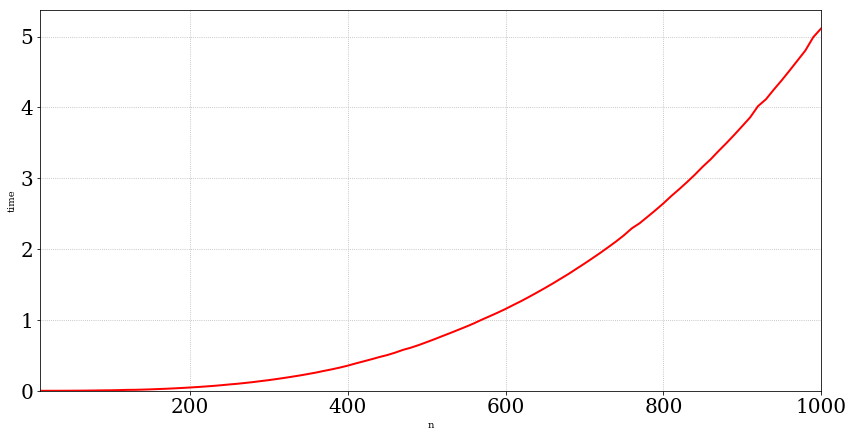

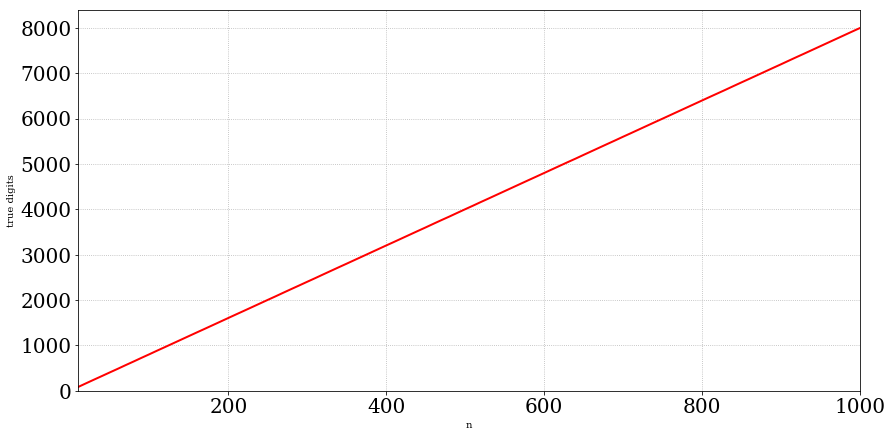

In [24]:
plot_pi_list(n_slow, pi_times, "time")
plot_pi_list(n_slow, pi_digits, "true digits")

We can see, that asymptotics of d(n) is linear. The ratio of true digits remains the same for any size of Pi for range from 0 to 1000.
From graph we can assume that asymptotics of t(n) is $N^2$. It increases faster than $NlogN$, but definatelly slower than $2^N$.
(This assumption is true, time complexity of this algorythm is $N^2$)

Using the Binary splitting technique we can construct a faster algorithm for calculating digits of $\pi$.

In [6]:
def q(a, b):
    m = (b-a)//2 + a
    if b - a == 1:
        return 3073907232*(b**3)
    return (q(a, m) * q(m, b))
def r(a, b):
    m = (b-a)//2 + a
    if b - a == 1:
        return (2*b - 1)*(4*b-3)*(4*b-1)
    return (r(a, m) * r(m, b))
    
def p(a, b):
    if b - a == 1:
        return (1103 + 26390*b)*(2*b - 1)*(4*b - 3)*(4*b - 1)
    m = (b-a)//2 + a
    return (p(a, m) * q(m, b) + p(m, b)*r(a, m))
    
def calculate_pi_fast(n):
    COEF = 10
    precision = COEF * n
    getcontext().prec = precision
    getcontext().Emax = MAX_EMAX
    pi = Decimal(9801 * q(0, n)) / Decimal(Decimal(2) * Decimal(2).sqrt()) / Decimal(p(0, n) + 1103*q(0, n))
    return pi

In [7]:
%%timeit
big_pi_fast = calculate_pi_fast(10 ** 4)

7.88 s ± 95 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [27]:
%%time
test_big_pi(calculate_pi_fast, n_max=5000)

number of terms = 1490, true digits = 11901, ratio = 7.987248322147651
number of terms = 2860, true digits = 22838, ratio = 7.985314685314686
number of terms = 4158, true digits = 33199, ratio = 7.984367484367485
number of terms = 4791, true digits = 38251, ratio = 7.9839281987059065
number of terms = 3068, true digits = 24498, ratio = 7.985006518904824
number of terms = 3875, true digits = 30940, ratio = 7.984516129032258
number of terms = 923, true digits = 7376, ratio = 7.991332611050921
number of terms = 363, true digits = 2904, ratio = 8.0
number of terms = 4721, true digits = 37693, ratio = 7.9841135352679515
number of terms = 2157, true digits = 17226, ratio = 7.986091794158553
CPU times: user 26min 34s, sys: 897 ms, total: 26min 35s
Wall time: 26min 36s


Comparing the execution time and the number of true digits for $N=10, 20, \ldots, 2000$.

In [28]:
%%time
n_fast = np.arange(10, 2001, 10)
pi_times_fast, pi_digits_fast = get_pi_times_and_digits(n_fast, func=calculate_pi_fast)

CPU times: user 28.5 s, sys: 17.4 ms, total: 28.6 s
Wall time: 28.6 s


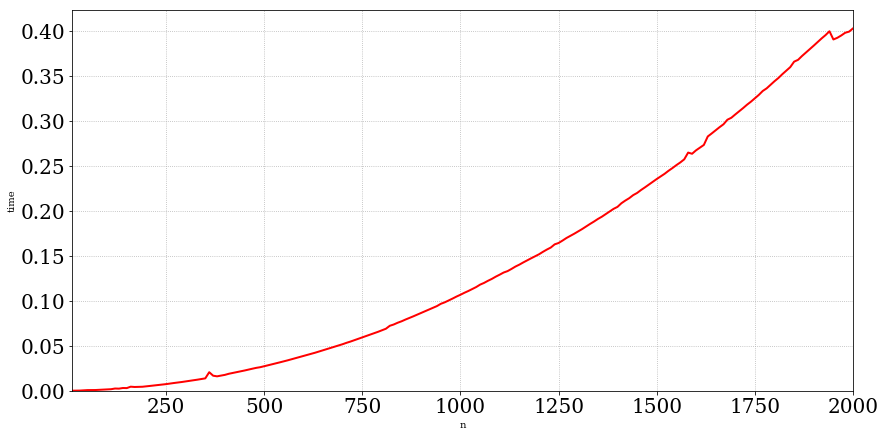

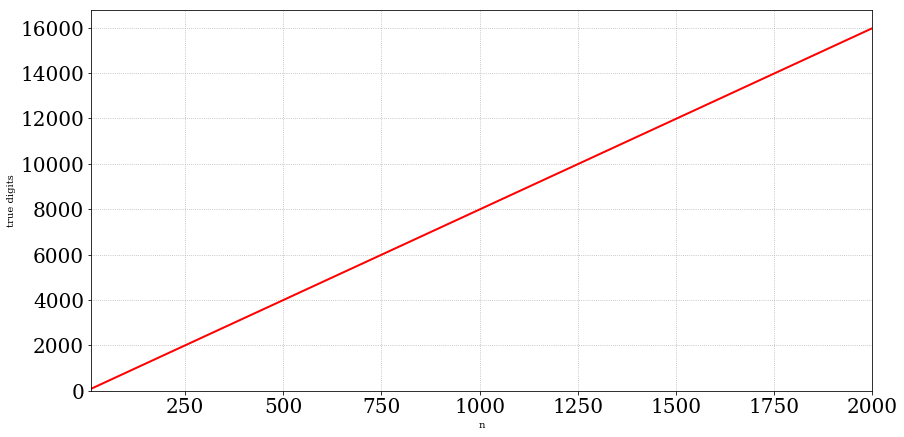

In [29]:
plot_pi_list(n_fast, pi_times_fast, "time")
plot_pi_list(n_fast, pi_digits_fast, "true digits")

Comparing slow and fast algorithms.

In [30]:
def plot_pi_times_both(range_list, times_list, labels):
    plt.figure(figsize=(14,7))
    colors = ['r', 'b', 'm', 'c']
    N_max = 0
    for i, times in enumerate(times_list):
        N = range_list[i][-1]
        N_max = max(N_max, N)
        plt.plot(range_list[i], times, c=colors[i], lw=2, label=labels[i])
    plt.xlim(1, N_max)
    plt.ylim(0)
    plt.xlabel("n")
    plt.ylabel("time, s")
    plt.grid()
    plt.legend();

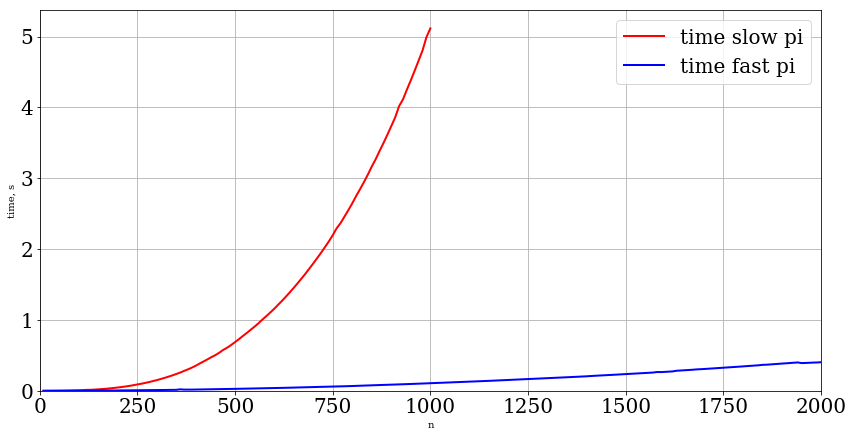

In [31]:
plot_pi_times_both([np.arange(10, 1001, 10),np.arange(10, 2001, 10)] , [pi_times, pi_times_fast] , ["time slow pi", "time fast pi"])

On this graph it is possible to see that complexity of the slow algorithm is $N^2$ and complexity of the fast is about $NlogN$ (because it is slower than $N^2$ and fater than $N$). To be more percise, complexity of the fast algorithm is $NlogN^3$.

Calculating more than 1 million of true digits of $\pi$:

In [8]:
%%time
big_pi = calculate_pi_fast(200000)
true_digits = check_number(str(big_pi), PATH_TO_DIGITS)
print("{} true digits of pi were calculated!".format(true_digits))

1596517 true digits of pi were calculated!
CPU times: user 1h 3min 10s, sys: 5.57 s, total: 1h 3min 15s
Wall time: 1h 3min 16s
